# import libraries

In [54]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
import mahotas
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV

# fuctions definition

In [2]:
def read_image(base_path, key, imgName):
    file_path = os.path.join(base_path, key[0] + "___" + key[1], imgName)

    img = cv2.imread(file_path)

    return img

In [3]:
# function returns a dictionary of images names sorted in this form {(plant, disease) : [img1, img2, ....]} where images stored in folders having names in this form plant___disease
def read_images_names(folder_path):
    
    # List all files in the dataset directory
    all_folder_names = os.listdir(folder_path)
    
    # store the names of training images depending on their folder names (plant___disease)
    images_names_dict = { (folder_name.split("___")[0], folder_name.split("___")[1]): os.listdir(os.path.join(folder_path, folder_name))
    for folder_name in all_folder_names }
    return images_names_dict

In [4]:
# n the number of images from each class
def sample_imgs_gray_resized(images_names_dict, new_dimensions, n):
    
    label=[]
    imgs_sample=[]
    for key, values in images_names_dict.items():
        for imgName in values[0:n]:
            label.append(list(key))
            img = read_image(train_dir, key, imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_AREA)/255
            flattened_image = img.flatten()
            imgs_sample.append(flattened_image)
            
    return imgs_sample, label

In [5]:
def sample_2Dimgs_gray_resized(images_names_dict, new_dimensions, n):
    
    label=[]
    imgs_sample=[]
    for key, values in images_names_dict.items():
        for imgName in values[0:n]:
            label.append(list(key))
            img = read_image(train_dir, key, imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_AREA)/255
            imgs_sample.append(img)
            
    return imgs_sample, label

In [6]:
def concat_columns(df):
    # Ensure the dataframe has at least two columns
    if df.shape[1] < 2:
        raise ValueError("Input dataframe must have at least two columns")
    
    # Concatenate the values of the first two columns
    concatenated_col = df.iloc[:, 0].astype(str) + '-' + df.iloc[:, 1].astype(str)
    
    # Create a new dataframe with the concatenated column
    new_df = pd.DataFrame({f'{df.columns[0]}.{df.columns[1]}': concatenated_col})
    
    return new_df

In [7]:
def create_table_and_save(x, y, filename='table.png'):
    # Create a DataFrame from the lists
    data = {'Name': x, 'Code': y}
    df = pd.DataFrame(data)
    
    # Plot the table
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    
    # Customize the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Calculate cell sizes based on text length
    max_col_width = [max(len(str(cell)) for cell in df[col]) for col in df.columns]
    cell_widths = [width * 0.1 for width in max_col_width]  # Adjust multiplier as needed

    # Adjust the size of the figure based on content
    fig_width = sum(cell_widths) + 2
    fig_height = len(df) * 0.4 + 1  # Adjust as needed

    fig.set_size_inches(fig_width, fig_height)
    
    # Set column widths
    for i, width in enumerate(cell_widths):
        table.auto_set_column_width(i)

    # Set colors for the cells
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:
            cell.set_facecolor('#f5f5f5' if i % 2 == 0 else '#e0e0e0')
    
    # Save the table as an image
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    # Show the plot (optional)
    plt.show()

In [8]:
import numpy as np
import cv2

def augment_image(image, num_augmentations=10):
    """
    Apply a series of augmentations to a single image using OpenCV.
    """
    augmented_images = []
    
    for _ in range(num_augmentations):
        # Randomly apply a series of augmentations
        augmented_image = image.copy()
        
        # Rotation
        angle = np.random.uniform(-20, 20)
        center = (augmented_image.shape[1] // 2, augmented_image.shape[0] // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        augmented_image = cv2.warpAffine(augmented_image, M, (augmented_image.shape[1], augmented_image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        
        # Horizontal Flip
        if np.random.random() > 0.5:
            augmented_image = cv2.flip(augmented_image, 1)
        
        # Random Translation
        tx = np.random.uniform(-0.2 * augmented_image.shape[1], 0.2 * augmented_image.shape[1])
        ty = np.random.uniform(-0.2 * augmented_image.shape[0], 0.2 * augmented_image.shape[0])
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        augmented_image = cv2.warpAffine(augmented_image, M, (augmented_image.shape[1], augmented_image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        
        # Random Zoom
        zoom = np.random.uniform(0.8, 1.2)
        M = cv2.getRotationMatrix2D(center, 0, zoom)
        augmented_image = cv2.warpAffine(augmented_image, M, (augmented_image.shape[1], augmented_image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        
        augmented_images.append(augmented_image)
    
    return augmented_images

def balance_dataset(images, labels):
    """
    Balance dataset by augmenting underrepresented classes.
    """
    # Count class occurrences
    class_counts = np.bincount(labels)
    max_count = max(class_counts)
    
    # Dictionary to hold lists of images for each class
    class_images = {i: [] for i in range(len(class_counts))}
    
    # Group images by their class
    for img, lbl in zip(images, labels):
        class_images[lbl].append(img)
    
    # Lists to hold balanced images and labels
    balanced_images = []
    balanced_labels = []
    
    for lbl, imgs in class_images.items():
        num_imgs = len(imgs)
        if num_imgs < max_count:
            # Augment images to match the max_count
            num_augmentations = (max_count - num_imgs) // len(imgs) + 1
            for img in imgs:
                augmented_images = augment_image(img, num_augmentations)
                balanced_images.extend(augmented_images)
                balanced_labels.extend([lbl] * len(augmented_images))
        else:
            balanced_images.extend(imgs)
            balanced_labels.extend([lbl] * num_imgs)
    
    return np.array(balanced_images), np.array(balanced_labels)


# Plant disease Classification with PCA + RandomForest

## load data (images)

In [9]:
# Directory containing the dataset
# Define paths relative to the script's location
current_dir = os.getcwd()
# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# train data dir
train_dir = os.path.join(parent_dir, 'plantReco/data/images/Plant_Diseases_Dataset/train')


In [10]:
train_images_names_dict = read_images_names(train_dir)

In [11]:
n=400
new_dim = (64, 64)

In [12]:
#train_imgs_sample_features, train_label=sample_imgs_gray_resized(train_images_names_dict, new_dim, n)

In [13]:
imgs_sample, labels=sample_2Dimgs_gray_resized(images_names_dict=train_images_names_dict, new_dimensions=new_dim, n=n)

In [16]:
labels_ar = np.array(labels)

In [17]:
imgs_sample = np.array(imgs_sample)

## plant type classification

### encode labels and balance data

In [18]:
plant_labels = labels_ar[:,0]

# Initialize LabelEncoders
plant_encoder = LabelEncoder()


# Encode labels
plant_labels_encoded = plant_encoder.fit_transform(plant_labels)



In [19]:
# plant data balancing
plant_imgs_sample_balanced,plant_labels_balanced = balance_dataset(imgs_sample, plant_labels_encoded)

In [20]:
plant_imgs_sample_balanced.shape

(53200, 64, 64)

In [21]:
plant_labels_balanced.shape

(53200,)

In [22]:
# number of images for each class for plant
for i in range(0,13):
    print(np.sum(plant_labels_balanced==i))

3200
4000
4000
3200
3200
4000
4000
4000
3600
4000
4000
4000
4000


In [23]:
plant_imgs_flattened = np.array([img.flatten()/255 for img in plant_imgs_sample_balanced])

In [24]:
plant_imgs_flattened.shape

(53200, 4096)

### find out the best PCA components numbers

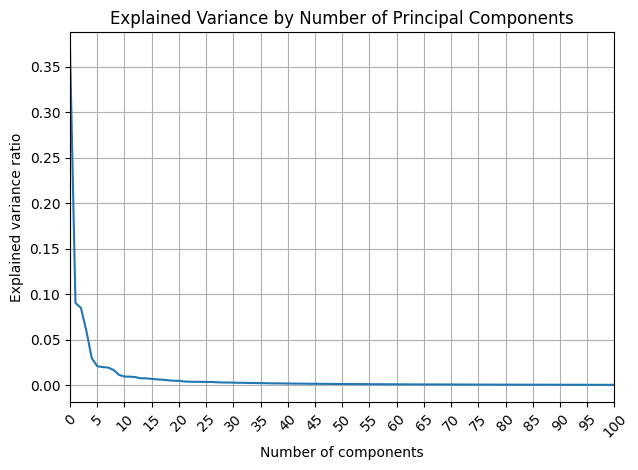

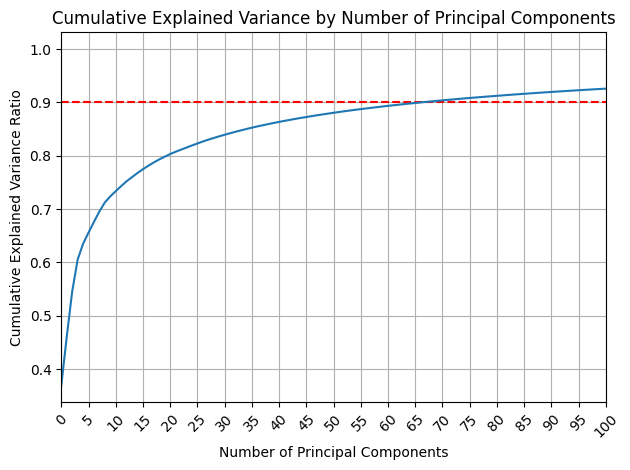

In [25]:
pca_all_plant = PCA()
pca_all_plant.fit(plant_imgs_flattened)

plt.figure()
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)  # Optionally add a grid for better readability
plt.xlim(0, 100)
# Set x-axis ticks with a step of 1
plt.xticks(range(0, 101, 5), rotation=45)
plt.tight_layout()  # Adjust the layout to make sure everything fits well
plt.plot(pca_all_plant.explained_variance_ratio_);
plt.savefig("pca_explained_variance_ratio.png")

plt.figure()
plt.xlim(0, 100)
# Set x-axis ticks with a step of 1
plt.xticks(range(0, 101, 5), rotation=45)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)  # Optionally add a grid for better readability
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.tight_layout()  # Adjust the layout to make sure everything fits well
plt.plot(pca_all_plant.explained_variance_ratio_.cumsum());
plt.savefig("pca_all_plant.png")

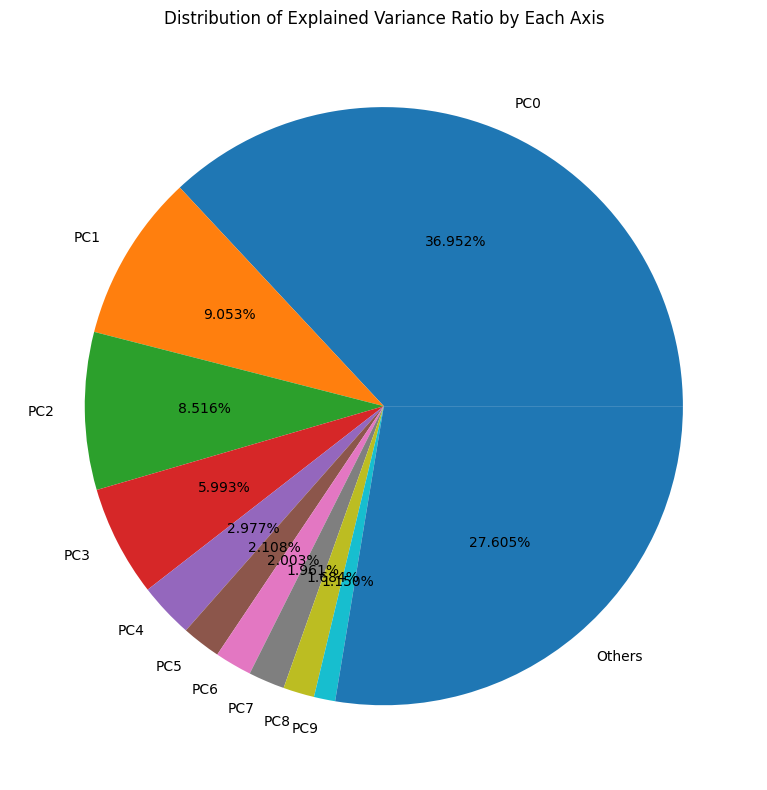

In [26]:

# Number of principal components
n_comp = 10

# Generate labels for the principal components
pca_labels_names = ['PC' + str(i) for i in range(n_comp)]
pca_labels_names.append('Others')

# Create the list of explained variance ratios
L1 = list(pca_all_plant.explained_variance_ratio_[0:n_comp])
L1.append(sum(pca_all_plant.explained_variance_ratio_[n_comp:]))

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(10, 8))

# Create the pie chart
ax.pie(L1, labels=pca_labels_names, autopct='%1.3f%%')

# Set the title
ax.set_title('Distribution of Explained Variance Ratio by Each Axis')

# Adjust the layout to make sure everything fits well
plt.tight_layout()

# Save the figure
plt.savefig("pca_all_plant_distribution_explained_variance.png")

# Display the figure
plt.show()


### PCA with specific number of components

In [45]:
# Initialize pca_plant to reduce to 10 components
pca_plant_n_comp = 70
pca_plant = PCA(n_components=pca_plant_n_comp  )

# Fit pca_plant on the features and transform the data
pca_plant_features = pca_plant.fit_transform(plant_imgs_flattened)

# Output the shapes of the original and reduced features
print("Original shape:", pca_plant_features.shape)
print("Reduced shape:", plant_imgs_flattened.shape)

Original shape: (53200, 70)
Reduced shape: (53200, 4096)


### Split data, build RandomForest model and train it

In [49]:
X_train_plant, X_test_plant, y_train_plant, y_test_plant = train_test_split(pca_plant_features, plant_labels_balanced, test_size=0.2, random_state=42, shuffle=True)

In [61]:
# Initialize the Random Forest model
model_plant_init = RandomForestClassifier(random_state=42)

# Define the parameter grid
"""
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
"""
param_grid = {
    'n_estimators': [100, 150]
}
# Initialize GridSearchCV with the Random Forest model and the parameter grid
grid_search = GridSearchCV(estimator=model_plant_init, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
# Fit GridSearchCV to the data
grid_search.fit(X_train_plant, y_train_plant)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# You can now use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_score = best_model.score(X_test_plant, y_test_plant)
print(f"Test Score: {test_score}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 150}
Best Score: 0.47015977443609025
Test Score: 0.48721804511278194


In [67]:
# Initialize and train the Random Forest model_plant
model_plant = RandomForestClassifier(n_estimators=250, random_state=42)
#model_plant = best_model
model_plant.fit(X_train_plant, y_train_plant)

RandomForestClassifier(n_estimators=250, random_state=42)

In [68]:
# Make predictions
y_pred_plant = model_plant.predict(X_test_plant)


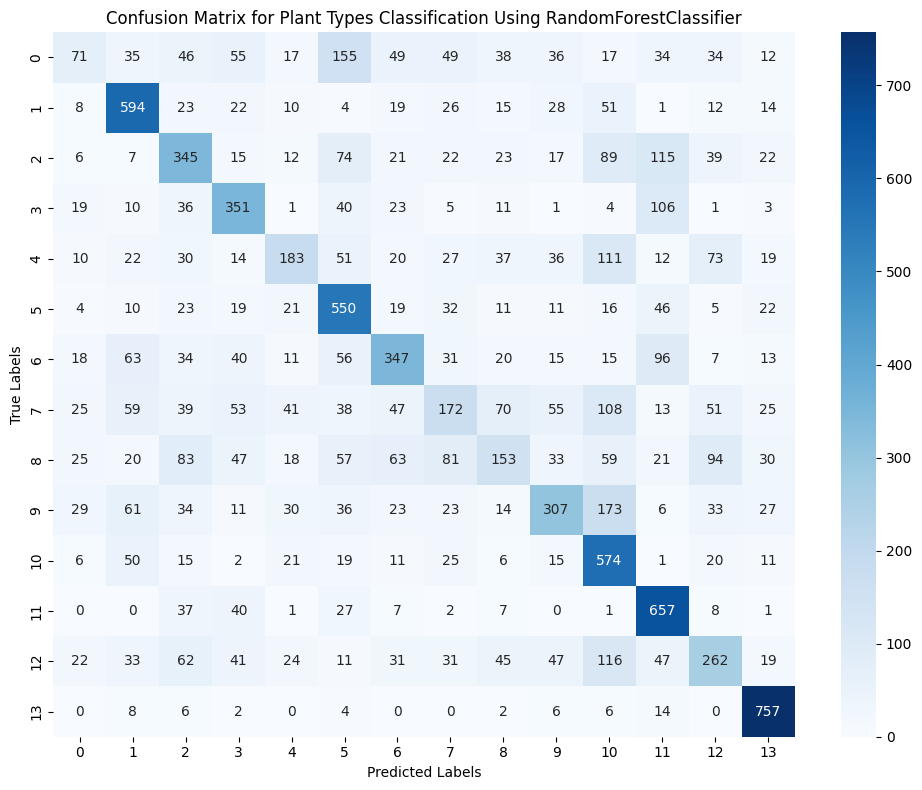

In [69]:
# Confusion Matrix
conf_mat_plant = confusion_matrix(y_test_plant, y_pred_plant)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_plant, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Plant Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("plant_types_balanced_Confusion_Matrix_RandomForestClassifier.png")
plt.show()

In [70]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test_plant, y_pred_plant))

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.11      0.16       648
           1       0.61      0.72      0.66       827
           2       0.42      0.43      0.43       807
           3       0.49      0.57      0.53       611
           4       0.47      0.28      0.35       645
           5       0.49      0.70      0.58       789
           6       0.51      0.45      0.48       766
           7       0.33      0.22      0.26       796
           8       0.34      0.20      0.25       784
           9       0.51      0.38      0.43       807
          10       0.43      0.74      0.54       776
          11       0.56      0.83      0.67       788
          12       0.41      0.33      0.37       791
          13       0.78      0.94      0.85       805

    accuracy                           0.50     10640
   macro avg       0.47      0.49      0.47     10640
weighted avg       0.48      0.50      0.47     10640



## disease type classification

### encode labels and balance data

In [36]:
disease_labels = labels_ar[:,1]
disease_encoder = LabelEncoder()
disease_labels_encoded = disease_encoder.fit_transform(disease_labels)

In [37]:
# disease data balancing
disease_imgs_sample_balanced,disease_labels_balanced = balance_dataset(imgs_sample, disease_labels_encoded)

In [38]:
disease_labels_balanced.shape

(100800,)

In [39]:
# number of images for each class for diseases
for i in range(0,13):
    print(np.sum(disease_labels_balanced==i))

4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800


In [40]:
disease_imgs_flattened = np.array([img.flatten()/255 for img in disease_imgs_sample_balanced])

### find out the best pca components number

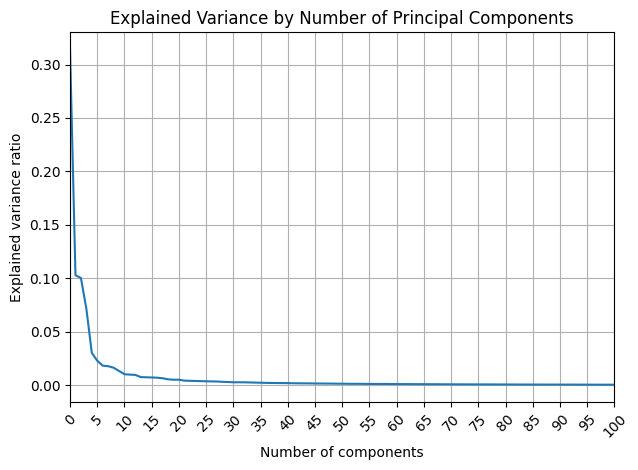

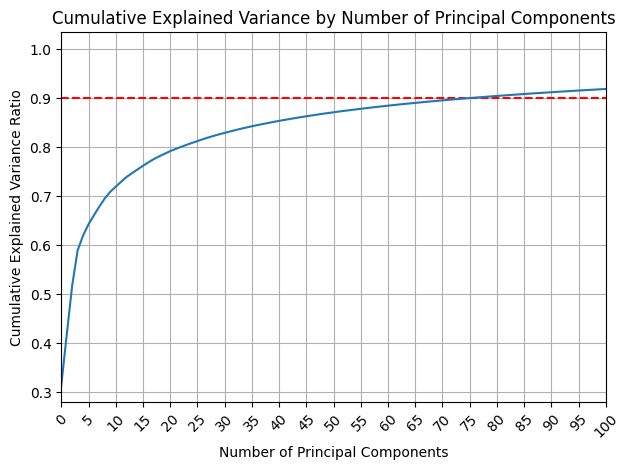

In [44]:
pca_all_disease = PCA()
pca_all_disease.fit(disease_imgs_flattened)

plt.figure()
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)  # Optionally add a grid for better readability
plt.xlim(0, 100)
# Set x-axis ticks with a step of 1
plt.xticks(range(0, 101, 5), rotation=45)
plt.tight_layout()  # Adjust the layout to make sure everything fits well
plt.plot(pca_all_disease.explained_variance_ratio_);
plt.savefig("pca_explained_variance_ratio.png")

plt.figure()
plt.xlim(0, 100)
# Set x-axis ticks with a step of 1
plt.xticks(range(0, 101, 5), rotation=45)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)  # Optionally add a grid for better readability
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.tight_layout()  # Adjust the layout to make sure everything fits well
plt.plot(pca_all_disease.explained_variance_ratio_.cumsum());
plt.savefig("pca_all_disease.png")

### PCA with specific number of components

In [64]:
# Initialize pca_disease to reduce to 10 components
pca_disease_n_comp = 70
pca_disease = PCA(n_components=pca_disease_n_comp  )

# Fit pca_disease on the features and transform the data
pca_disease_features = pca_disease.fit_transform(disease_imgs_flattened)

# Output the shapes of the original and reduced features
print("Original shape:", pca_disease_features.shape)
print("Reduced shape:", disease_imgs_flattened.shape)

Original shape: (100800, 70)
Reduced shape: (100800, 4096)


### Split data, build RandomForest model and train it

In [65]:
X_train_disease, X_test_disease, y_train_disease, y_test_disease = train_test_split(pca_disease_features, disease_labels_balanced, test_size=0.2, random_state=42, shuffle=True)

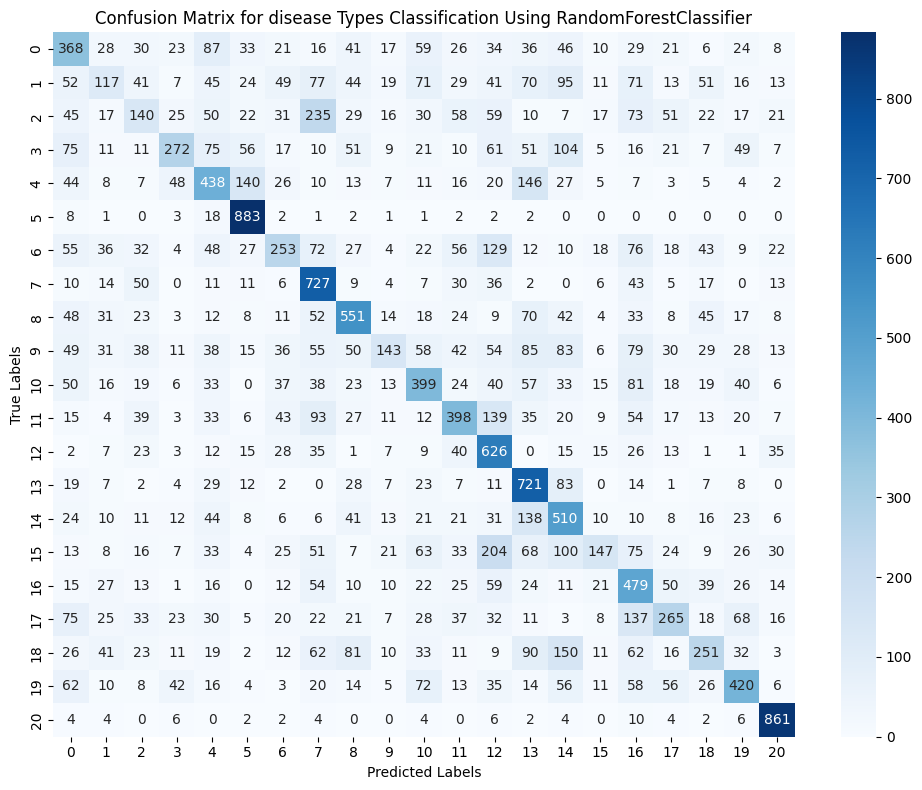

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.38      0.36       963
           1       0.26      0.12      0.17       956
           2       0.25      0.14      0.18       975
           3       0.53      0.29      0.37       939
           4       0.40      0.44      0.42       987
           5       0.69      0.95      0.80       926
           6       0.39      0.26      0.31       973
           7       0.44      0.73      0.55      1001
           8       0.51      0.53      0.52      1031
           9       0.42      0.15      0.22       973
          10       0.41      0.41      0.41       967
          11       0.44      0.40      0.42       998
          12       0.38      0.68      0.49       914
          13       0.44      0.73      0.55       985
          14       0.36      0.53      0.43       969
          15       0.45      0.15      0.23       964
          16       0.33      0.52      0.41       928
    

In [66]:
# Initialize and train the Random Forest model_disease
model_disease = RandomForestClassifier(n_estimators=150, random_state=42)
model_disease.fit(X_train_disease, y_train_disease)

# Make predictions
y_pred_disease = model_disease.predict(X_test_disease)


# Confusion Matrix
conf_mat_disease = confusion_matrix(y_test_disease, y_pred_disease)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_disease, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for disease Types Classification Using RandomForestClassifier')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("disease_types_balanced_Confusion_Matrix_RandomForestClassifier.png")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_disease, y_pred_disease))